In [1]:
%load_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import os
import requests
import seaborn as sns

In [3]:
from functions.drees import DREES

In [4]:
# Init -> this create required folders
drees = DREES()

In [5]:
drees.get_covid_dataset_list()

['covid-19-anciens-resultats-regionaux-issus-des-appariements-entre-si-vic-si-dep-',
 'covid-19-avant-amelioration-resultats-par-age-issus-des-appariements-entre-si-vi',
 'covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si',
 'covid-19-avant-amelioration-resultats-nationaux-issus-des-appariements-entre-si-',
 'covid-19-avant-amelioration-resultats-regionaux-issus-des-appariements-entre-si-',
 'covid-19-anciens-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et',
 'covid-19-anciens-resultats-nationaux-issus-des-appariements-entre-si-vic-si-dep-',
 'covid-19-resultats-issus-des-appariements-entre-si-vic-si-dep-et-vac-si',
 'covid-19-resultats-regionaux-issus-des-appariements-entre-si-vic-si-dep-et-vac-s']

In [6]:
[ds for ds in drees.get_covid_dataset_list() if "age" in ds]

['covid-19-avant-amelioration-resultats-par-age-issus-des-appariements-entre-si-vi',
 'covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si',
 'covid-19-anciens-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et']

# Vérification des affirmations de Mr Véran

## Check affirmation of Oliver Veran made the 13/07/2021
En France, dans 30 gros hôpitaux, 100 % des patients récemment admis en réanimation ne sont pas vaccinés et 93% de ceux admis en médecine ne sont pas vaccinés.


In [8]:
ds = xr.open_dataarray("data/ds_national.nc")
# ds = ds.resample(date="W").mean()  # weekly resampling to filter week-end artefact on death registered on monday
ds_binary = drees.group_vac_statut(ds, binary=True)
ds_binary_normed = ds_binary / ds_binary.sum(dim="vac_statut")

sc
hc
nb_pcr0
sc_pcr
hc_pcr
nb_pcr_sympt0


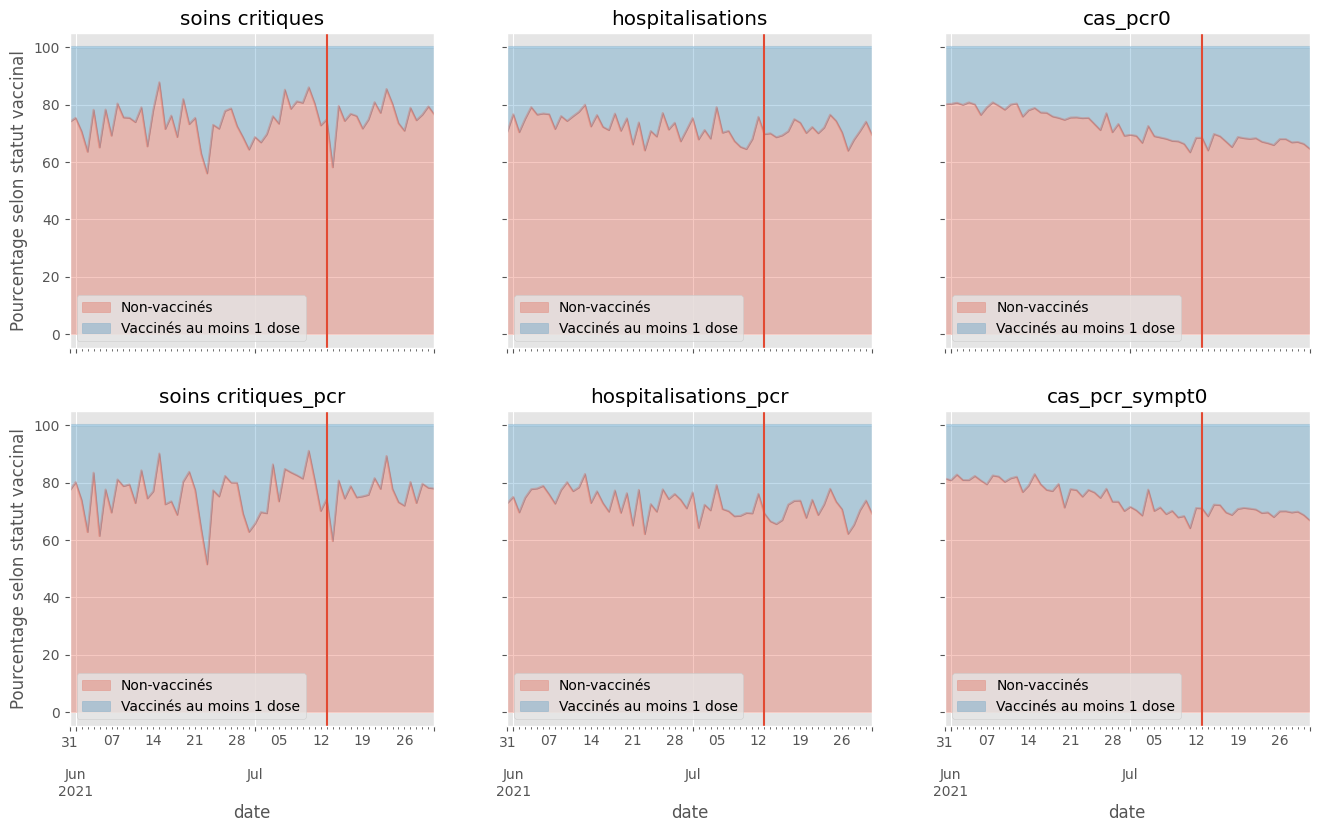

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(16, 9), sharex=True, sharey=True)
ax = ax.ravel()

for i, variable in enumerate(
    ["sc", "hc", "nb_pcr0", "sc_pcr", "hc_pcr", "nb_pcr_sympt0"]
):
    print(variable)
    dfp = (
        ds_binary_normed.sel(version="resultats", variable=variable)
        .to_dataset("vac_statut")
        .to_dataframe()
    ) * 100
    dfp.loc[:"2021-07"].plot(kind="area", stacked=True, ax=ax[i], alpha=0.3)
    ax[i].set_title(
        variable.replace("sc", "soins critiques")
        .replace("hc", "hospitalisations")
        .replace("nb", "cas")
    )
    ax[i].axvline(x="2021-07-13")
    ax[i].set_ylabel("Pourcentage selon statut vaccinal")

## Fevrier 2022: 500 enfant hospitalisé pour COVID

In [11]:
ds_age = xr.load_dataarray("data/ds_by_age.nc")
ds_age = ds_age.resample(date="W").sum()
ds_age_grouped = drees.group_vac_statut(ds_age)
ds_age_grouped_normalised = ds_age_grouped.sel(version="avant") / ds_age_grouped.sel(
    version="avant"
).sel(variable="effectif")
ds_age_grouped_binary = drees.group_vac_statut(ds_age, binary=True)
ds_age_grouped_normalised_binary = ds_age_grouped_binary.sel(
    version="avant"
) / ds_age_grouped_binary.sel(version="avant").sel(variable="effectif")

Text(0, 0.5, 'Hospitalisation par semaine')

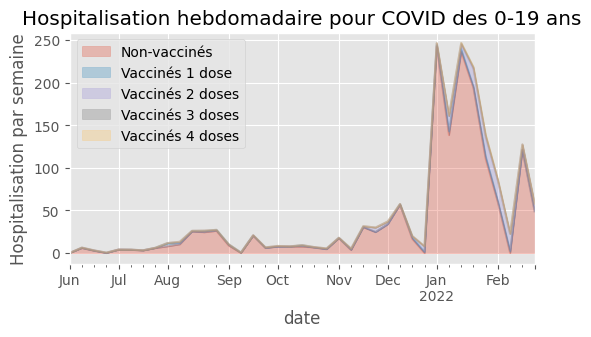

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
dfp = (
    ds_age_grouped.sel(age="[0,19]", variable="hc_pcr_pour_covid", version="resultats")
    .to_dataset("vac_statut")
    .to_dataframe()
)
dfp[:"2022-02"].plot(kind="area", stacked=True, alpha=0.3, ax=ax)
ax.set_title("Hospitalisation hebdomadaire pour COVID des 0-19 ans")
ax.set_ylabel("Hospitalisation par semaine")
# ax.axhline(y=500)

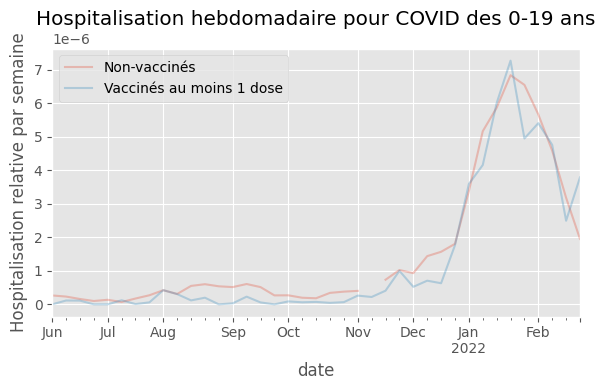

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
dfp = (
    ds_age_grouped_normalised_binary.sel(age="[0,19]", variable="hc_pcr_pour_covid")
    .to_dataset("vac_statut")
    .to_dataframe()
)
dfp[:"2022-02"].plot(kind="line", alpha=0.3, ax=ax)
ax.set_title("Hospitalisation hebdomadaire pour COVID des 0-19 ans")
ax.set_ylabel("Hospitalisation relative par semaine")
# ax.axhline(y=500)
plt.tight_layout()

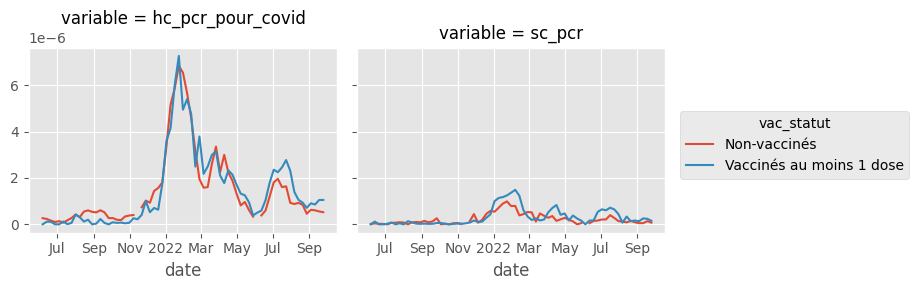

In [14]:
ds_age_grouped_normalised_binary.sel(
    age="[0,19]", variable=["hc_pcr_pour_covid", "sc_pcr"]
).plot(hue="vac_statut", col="variable")

In [16]:
cas = ds_age_grouped_binary.sel(age="[0,19]", variable="nb_pcr0")
sc = ds_age_grouped_binary.sel(age="[0,19]", variable="sc_pcr")

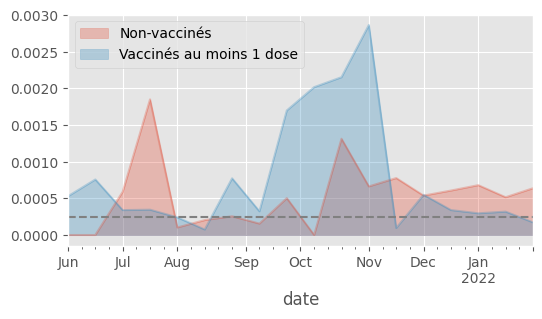

In [18]:
dfp = (
    (sc.resample(date="2W").sum() / cas.resample(date="2W").sum())
    .sel(date=slice("2021-01", "2022-01"))
    .sel(version="resultats")
    .to_dataset("vac_statut")
    .to_dataframe()
)
fig, ax = plt.subplots(figsize=(6, 3))
dfp.plot(ax=ax, kind="area", stacked=False, alpha=0.3)
ax.axhline(y=1 / 4000, ls="--", color="grey")
# ax.axhline(y=1 / 1000, ls="--", color="grey")

In [19]:
df = (
    (
        sc.sel(date=slice("2021-06", "2022-01")).sum("date")
        / cas.sel(date=slice("2021-06", "2022-01")).sum("date")
    )
    .to_dataset("vac_statut")
    .to_dataframe()
)
df

,Non-vaccinés,Vaccinés au moins 1 dose,age
version,,,
avant,0.000513,0.000587,"[0,19]"
resultats,0.000515,0.000274,"[0,19]"
anciens,0.000540,0.000409,"[0,19]"


In [20]:
1 / 4000

0.00025

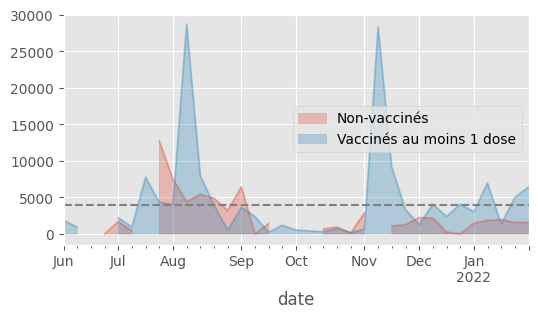

In [21]:
dfp = (
    (cas.resample(date="W").sum() / sc.resample(date="W").sum())
    .sel(date=slice("2021-01", "2022-01"))
    .sel(version="resultats")
    .to_dataset("vac_statut")
    .to_dataframe()
)
fig, ax = plt.subplots(figsize=(6, 3))
dfp.plot(ax=ax, kind="area", stacked=False, alpha=0.3)
ax.axhline(y=4000, ls="--", color="grey")

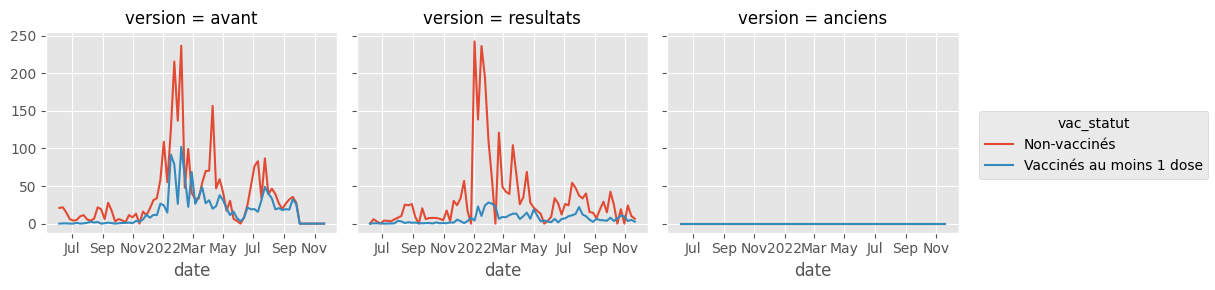

In [22]:
ds_age_grouped_binary.sel(age="[0,19]", variable="hc_pcr_pour_covid").plot(
    hue="vac_statut", col="version"
)

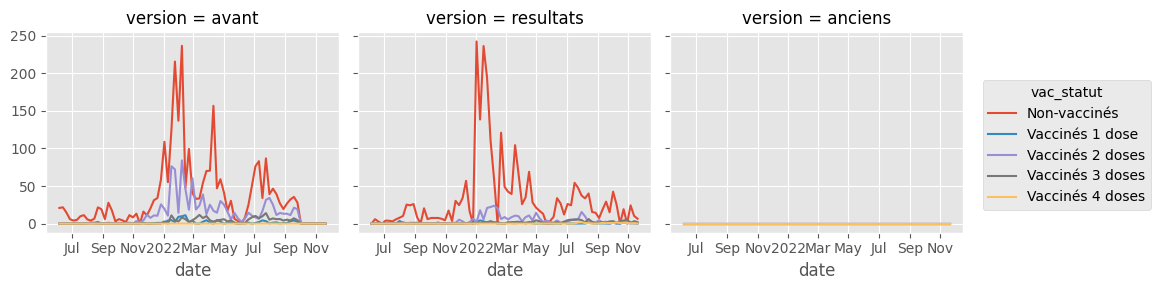

In [23]:
ds_age_grouped.sel(age="[0,19]", variable="hc_pcr_pour_covid").plot(
    hue="vac_statut", col="version"
)